# Add a Training Loop

In [0]:
import numpy as np 
from sklearn import metrics

import numpy as np 
from sklearn import metrics

def loss(y_true, y_predicted, loss_function='mse'):
    if loss_function == 'mse':       
        return metrics.mean_squared_error( y_true, y_predicted)
    else:
        raise Exception('Loss metric is not defined.')

def get_dz_from_loss(y, y_predicted, metric):
    if metric == 'mse':
        return y_predicted - y
    else:
        raise Exception('Loss metric is not defined.')

def sigma(z, act_func):
    global _activation
    if act_func == 'relu':
       return np.maximum(z, np.zeros(z.shape))
    
    elif act_func == 'sigmoid':
      return 1.0/(1.0 + np.exp( -z ))

    elif act_func == 'linear':
        return z
    else:
        raise Exception('Activation function is not defined.')

def sigma_prime(z, act_func):
    if act_func == 'relu':
        return np.maximum(np.sign(z), np.zeros(z.shape)) # 1 if backward input >0, 0 otherwise; then diaganolize

    elif act_func == 'sigmoid':
        h = sigma(z, 'sigmoid')
        return h *(1-h)

    elif act_func == 'linear':
        return np.ones(z.shape)

    else:
        raise Exception('Activation function is not defined.')

class Layer:
    def __init__(self,input_dim, output_dim, activation_function='linear'):    
        self.activation = activation_function
        self.input_dim = input_dim
        self.output_dim = output_dim 
        if input_dim > 0:
            #self.b = np.random.randn( output_dim, 1 )       
            #self.W = np.random.randn( output_dim, input_dim )
            #self.dW = np.random.randn( output_dim, input_dim )
            #self.db = np.random.randn( output_dim, 1 )
            self.b  = np.ones( (output_dim, 1) )       
            self.W  = np.ones( (output_dim, input_dim) )
            self.dW = np.ones( (output_dim, input_dim) )
            self.db = np.ones( (output_dim, 1) )
        self.a = np.zeros( (output_dim,1) )

    
    def set_weight(self, W ):
        self.W = W
      
    def set_bias(self, b ):
        self.b = b
  
    def compute_activation(self, a ): 
        self.z =  np.add( np.dot(self.W, a), self.b)
        self.a =  sigma(self.z, self.activation)
    
    
    def print( self ):      
        print(f"\n====== Layer Info =======")
        print(f"a    = {self.a}")
        if self.input_dim > 0: 
          print(f"W   =  {self.W}")          
          print(f"b   =  {self.b}")  
    

class Model:
    def __init__(self, input_dim):  
        self.neural_net = []
        self.neural_net.append(Layer(0 , input_dim, 'irrelevant'))    

    def fit(self, training_data, epochs, learning_rate=0.001, verbose=1 ):
          self.learning_rate = learning_rate
          
          X_train, y_train = training_data
          num_train_datum = X_train.shape[1]

          print(f"\n\nStart training for following parameters :")
          print(f" N              =  {num_train_datum}")
          print(f" Shape of X     =  {X_train.shape}")
          print(f" Shape of y     =  {y_train.shape}")
          print(f" epochs         = {epochs}")
          print(f" learning_rate  =  {learning_rate}")
    
          
          # Training Loop
          for epoch in range(1,epochs+1):        
              y_train_predicted = model.forward_propagation( X_train )
              self.backward_propagation( y_train, y_train_predicted, num_train_datum, verbose = verbose - 1 )
              self.update( learning_rate )
                            
              ##  - Backpropagation for whole training set is finished
              
              # After backpropagation
              # ... calculate the training loss
              y_train_predicted = model.forward_propagation( X_train )
              training_loss   = loss(y_train, y_train_predicted)
                            
              # If requested, print result of this round
              if (verbose > 0):
                print(f"Epoch {epoch}: Train.-Loss   = { training_loss  }")

          ##### end of training loop 
          return training_loss


    def add_layer(self, nr_neurons, activation='relu'):    
        layer_index = len(self.neural_net)
        input_dim = self.neural_net[layer_index - 1].output_dim
        new_layer = Layer( input_dim, nr_neurons, activation)
        self.neural_net.append( new_layer )


    def forward_propagation(self, input_vec ):
        self.neural_net[0].a = input_vec
        for layer_index in range(1,len(self.neural_net)):    
            _A_Prev = self.neural_net[layer_index-1].a                       
            self.neural_net[layer_index].compute_activation( _A_Prev )
        return  self.neural_net[layer_index].a
  
    def backward_propagation(self, y, y_predicted, num_train_datum, metric='mse', verbose=0):   
            nr_layers = len(self.neural_net)
            for layer_index in range(nr_layers-1,0,-1):
                if layer_index+1 == nr_layers: # if output layer

                    dz = np.multiply(get_dz_from_loss(y, y_predicted, metric), 
                                    sigma_prime(
                                        self.neural_net[layer_index].a, 
                                        self.neural_net[layer_index].activation)
                    )        
                else: 
                    dz = np.multiply(
                          np.dot(
                              self.neural_net[layer_index+1].W.T, 
                              dz), 
                          sigma_prime(
                                self.neural_net[layer_index].a, 
                                self.neural_net[layer_index].activation)
                          )         
                dW = np.dot(dz, self.neural_net[layer_index-1].a.T) / num_train_datum
                db = np.sum(dz, axis=1, keepdims=True) / num_train_datum

                # Update gradients
                self.neural_net[layer_index].dW = dW 
                self.neural_net[layer_index].db = db 

                if (verbose > 0):
                  print(f"\n\n====== Backward Propagation Layer {layer_index} =======")
                  print(f"dZ      =  {dz}")          
                  print(f"dW      =  {dW}")
                  print(f"db      =  {db}")
                  print(f"A           = {self.neural_net[layer_index].a}") 
                  print(f"A prev lay  = {self.neural_net[layer_index-1].a}") 
                  

    def update( self, learning_rate ):
        nr_layers = len(self.neural_net)
        for layer_index in range(1,nr_layers):        
            self.neural_net[layer_index].set_weight( self.neural_net[layer_index].W - learning_rate * self.neural_net[layer_index].dW )
            self.neural_net[layer_index].set_bias(  self.neural_net[layer_index].b  - learning_rate * self.neural_net[layer_index].db  )
    

    def summary(self):
        print("MODEL SUMMARY")
        for layer_index in range(len(self.neural_net)):        
          self.neural_net[layer_index].print()
          
        print("FINISHED MODEL SUMMARY")
            


# Test

In [9]:
#Testing---------------------------------        
input_dim = 2
output_dim = 1
model = Model( input_dim )
#model.add_layer( 2, 'linear' )
model.add_layer( output_dim, 'linear' )

# Play with different feature set lengths..
# N=1
X  = np.array([[1,1]])
y  = np.array( [[22]] )

# N=2
#X  = np.array( [[0.,1.], [0.,1.]] ) 
#y_true = np.array( [[0., 7.]] )


# N=3
#X  = np.array( [[0.,1., 2.0], [0.,1., 2.0]] ) 
#y_true = np.array( [[-10., -11., -15.0]] )

print( y.shape )
model.fit( (X.T, y) , 1000, verbose=1)


(1, 1)


Start training for following parameters :
 N              =  1
 Shape of X     =  (2, 1)
 Shape of y     =  (1, 1)
 epochs         = 1000
 learning_rate  =  0.001
Epoch 1: Train.-Loss   = 358.83724900000004
Epoch 2: Train.-Loss   = 356.68745504124104
Epoch 3: Train.-Loss   = 354.550540498089
Epoch 4: Train.-Loss   = 352.42642820996497
Epoch 5: Train.-Loss   = 350.31504147855895
Epoch 6: Train.-Loss   = 348.21630406506097
Epoch 7: Train.-Loss   = 346.1301401874072
Epoch 8: Train.-Loss   = 344.0564745175444
Epoch 9: Train.-Loss   = 341.99523217870984
Epoch 10: Train.-Loss   = 339.94633874272716
Epoch 11: Train.-Loss   = 337.90972022731955
Epoch 12: Train.-Loss   = 335.88530309343764
Epoch 13: Train.-Loss   = 333.8730142426049
Epoch 14: Train.-Loss   = 331.8727810142774
Epoch 15: Train.-Loss   = 329.8845311832209
Epoch 16: Train.-Loss   = 327.90819295690216
Epoch 17: Train.-Loss   = 325.9436949728974
Epoch 18: Train.-Loss   = 323.9909662963148
Epoch 19: Train.-Loss   = 322.049936

0.8867962035955237

# Check with Keras (optional todo move somewhere else)

X Shape : (3, 2)
Y_true Shape : (3, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
[array([[-0.6689986],
       [ 1.2921003]], dtype=float32), array([0.], dtype=float32)]


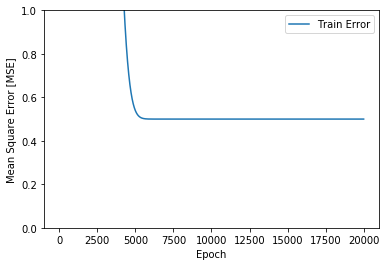

[[ -9.5]
 [-12. ]
 [-14.5]]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [MSE]')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')

  plt.ylim([0,1])
  plt.legend()
  plt.show()


X  = np.array( [[0.,1., 2.0], [0.,1., 2.0]] ).T 
y_true = np.array( [[-10., -11., -15.0]] ).T
print(f"X Shape : { X.shape}" )
print(f"Y_true Shape : { y_true.shape}" )


model = Sequential()
model.add(Dense(2, input_dim=2, activation='relu')) # Hidden 1
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

w0 = []
w0.append(np.array([[1,1],[1,1]]))  # Weight Vectors in rows
w0.append(np.array( [1,1] ))        # Bias
#model.layers[0].set_weights( w0 )

w1 = []
w1.append(np.array([[1],[1]]))
w1.append(np.array( [1] ))  
#model.layers[1].set_weights( w1 )

print( model.layers[1].get_weights() )


history = model.fit(X,y_true,verbose=0,epochs=20000)

plot_history( history )

y = model.predict( X )
print( y )

